In [2]:
# TODO add utils (for like IO / data handling) specific to melody generation

from enum import Enum
from os import walk, listdir
import os.path

from tqdm import tqdm
from music21.note import Note, Rest
from music21.pitch import Pitch
from music21.duration import Duration


class Columns(Enum):
    Sira = 0
    Kod = 1
    Nota53 = 2
    NotaAE = 3
    Koma53 = 4
    KomaAE = 5
    Pay = 6
    Payda = 7
    Ms = 8
    LNS = 9
    Bas = 10
    Soz1 = 11
    Offset = 12


CODE_NOTE = 9
CODE_REST = "Es"
OneCommaInCents = 21.51 # according to Wikipedia

SYMBTR_TXT_FOLDER = "/Users/sercanatli/Workspaces/SymbTr/txt"

def parse_symbtr_txt(filename):
    '''Parses given symbtr, returns music21 (Note, Duration)'''

    note_list = []
    
    file = open(filename)
    for index, line in enumerate(file):
        if (index == 0):
            continue
    
        split_line = line.strip().split("\t")
    
        if (int(split_line[Columns.Kod.value])) == CODE_NOTE:
            parsed_note = split_line[Columns.NotaAE.value]
    
            # note name
            note_name = parsed_note[:2]
            accidental = None
    
            if (len(parsed_note) > 2):
                accidental = parsed_note[2:]        
    
            # note length
            pay = int(split_line[Columns.Pay.value])
            payda = int(split_line[Columns.Payda.value])
    
            # calculate microtone
            if (accidental):
                signature = 1 if accidental[0] == "#" else -1
                microtone = signature * int(accidental[1]) * OneCommaInCents

            if (parsed_note == CODE_REST):
                note = Rest()
            else:
                note = Pitch(step=parsed_note[0], 
                             octave=int(parsed_note[1]),
                             accidental=None,
                             microtone=microtone if accidental else None)

            duration = Duration()
            duration.quarterLength = (pay/payda) / (1/4)
            note_list.append((note, duration))
    file.close()
    
    return note_list


def get_training_data(makam):
    training_data = []
    scores = [symbtr for symbtr in listdir(SYMBTR_TXT_FOLDER) if symbtr.split("--")[0] == makam]

    for score_file in tqdm(scores):
        training_data.append(parse_symbtr_txt(os.path.join(SYMBTR_TXT_FOLDER, score_file)))

    return training_data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 571.87it/s]


C5(-22c)
D5(-86c)
D5(-86c)
C5(-22c)
C5(-22c)
B4(-86c)
B4(-86c)
C5(-22c)
B4(-86c)
A4(+86c)
A4(+86c)
C5(-22c)
B4(-86c)
B4(-86c)
C5(-22c)
B4(-86c)
C5(-22c)
D5(-86c)
C5(-22c)
D5(-86c)
C5(-22c)
C5(-22c)
D5(-86c)
E5(+86c)
F5(+22c)
E5(+86c)
D5(-86c)
E5(+86c)
F5(+22c)
G5(-86c)
F5(+22c)
E5(+86c)
E5(+86c)
E5(+86c)
E5(+86c)
B4(-86c)
B4(-86c)
C5(-22c)
D5(-86c)
E5(+86c)
F5(+22c)
E5(+86c)
F5(+22c)
E5(+86c)
D5(-86c)
B4(-86c)
C5(-22c)
D5(-86c)
C5(-22c)
D5(-86c)
C5(-22c)
B4(-86c)
A4(+86c)
B4(-86c)
D5(-86c)
C5(-22c)
C5(-22c)
B4(-86c)
D5(-86c)


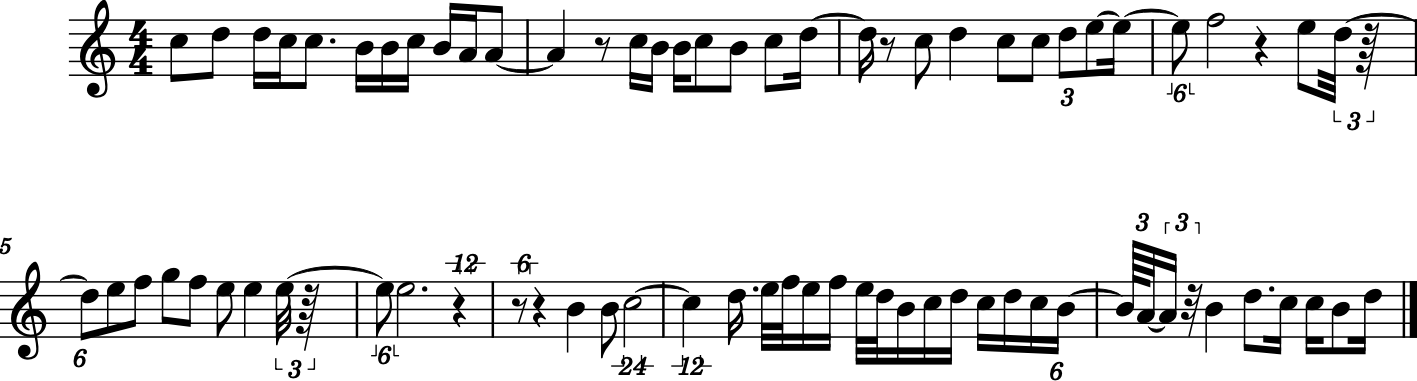

CPU times: user 450 ms, sys: 35.9 ms, total: 486 ms
Wall time: 2.03 s


'/Users/sercanatli/Desktop/output_generated.mid'

In [3]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

training_data=[]
states = set()
saba_pitches = set()

# you can change the name of makam to get a training data
# list of lists containing music21 notes
saba_data = get_training_data("saba")
for composition in saba_data:
    note_list = []
    note = None

    for pitch, duration in composition:
        if (pitch.name == "rest"):
            note = Rest(duration=duration)
        else:
            note = Note(pitch, duration=duration)
        note_list.append(note)
    training_data.append(note_list)


# TODO! put the logic somewhere else to generate states
for composition in saba_data:
    for note_pair in composition:
        saba_pitches.add(note_pair[0])
        states.add((note_pair[0].nameWithOctave if note_pair[0].name != "rest" else "Rest", note_pair[1].quarterLength))


model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(states))
model.train(training_data)

saba_melody, _ = model.generate(64)

from music21 import stream

score = stream.Score()
part = stream.Part()

# fix this loop here! something is wrong
for note in saba_melody:
    for pitch in list(saba_pitches):
        if pitch.name == "rest": 
            continue
        elif note[0] == "Rest":
            part.append(Rest(note[1]))
            break
        elif note[0] == pitch.nameWithOctave:
            print(pitch)
            part.append(Note(pitch, quarterLength=note[1]))
            break

score.append(part)
score.show('midi')
score.show()

output_path = "/Users/sercanatli/Desktop/output_generated.mid"
score.write('midi', fp=output_path)

In [1]:
from music21 import metadata, note, stream

symbtr_path = "/Users/sercanatli/Workspaces/SymbTr/txt/saba--aranagme--senginsemai--1--.txt"
melody = parse_symbtr_txt(symbtr_path)

score = stream.Score()
score.metadata = metadata.Metadata(title=symbtr_path)
part = stream.Part()

for pitch, duration in melody:
    if (pitch.name == "rest"):
        part.append(Rest(duration=duration))
    else:
        part.append(Note(pitch, duration=duration))

score.append(part)
score.show('midi')
score.show()

NameError: name 'parse_symbtr_txt' is not defined